In [1]:
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON
from dateutil import parser
import isodate
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from dateutil import parser

#NLP
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
# nltk.download('stopwords')

#functions
from utils import *

#read .env
import os
from dotenv import load_dotenv

In [2]:
load_dotenv()
api_key = os.getenv('API_KEY')

In [3]:
api_service_name = "youtube"
api_version = "v3"

#get credentials and create API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

ids = ["UCBJycsmduvYEL83R_U4JriQ"] #this time we do for MKBHD's channel only

# usernames = ["LinusTechTips"]

# for name in usernames:
#     userId = find_channel_by_user_name(youtube, name)
#     if userId: 
#         ids.append(userId)


In [4]:
channels_df = get_channel_stats(youtube, ids)
playlist_id = channels_df["playlistId"][0]
video_ids = get_video_from_playlist(youtube, playlist_id)

In [5]:
videos_df = get_all_videos_info(youtube, video_ids)
# videos_df.describe

## To analyze:

- Views per video
- Likes and comments vs views
- Title length vs views
- Video duration
- Video upload schedules

# Data preprocessing

In [6]:
videos_df_copy = videos_df.copy()

In [7]:
videos_df.isnull().any()

video_id        False
channelTitle    False
title           False
description     False
tags             True
publishedAt     False
viewCount        True
likeCount        True
commentCount     True
duration        False
definition      False
dtype: bool

In [8]:
videos_df.dtypes

video_id        object
channelTitle    object
title           object
description     object
tags            object
publishedAt     object
viewCount       object
likeCount       object
commentCount    object
duration        object
definition      object
dtype: object

In [9]:
numeric_cols = ['viewCount', 'likeCount', 'commentCount']
videos_df[numeric_cols] = videos_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1) 

In [10]:
#Publish day of the week
videos_df['publishedAt'] = videos_df['publishedAt'].apply(lambda x: parser.parse(x))
videos_df['publishedAt'] = videos_df['publishedAt'].apply(lambda x: x.day_of_week)

In [11]:
date_name = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
videos_df['publishedAt'] = videos_df['publishedAt'].apply(lambda x: date_name[x])

In [12]:
videos_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition
0,bMLbnsKGRfo,Marques Brownlee,How Apple is Taking Back the iPhone,The evolution of the iPhone through integratio...,None,Fri,1828744.0,84109.0,2694.0,PT8M16S,hd
1,va6QudutbAY,Marques Brownlee,The Secret F150 Lightning Feature...,An alternate way of measuring F150 Lightning's...,"[F150 Lightning, F150, front trunk, frunk, MKBHD]",Thu,267061.0,13108.0,193.0,PT21S,hd
2,9kxTOxDGLqs,Marques Brownlee,Galaxy S23 / Ultra Impressions: Cruise Control!,Samsung's flagships for 2023 are a small bump ...,"[S23, Galaxy S23, Samsung, Samsung Galaxy S23,...",Wed,2916638.0,106912.0,6977.0,PT6M49S,hd
3,gvqZCMGjh3s,Marques Brownlee,Apple HomePod 2 Review: I'm Confused,The second generation HomePod is really good. ...,"[HomePod, HomePod 2, MKBHD, HomePod vs, Homepo...",Tue,2455351.0,94909.0,4937.0,PT10M3S,hd
4,7V_XEgSjrM0,Marques Brownlee,The #1 Most Overpriced Tech in 2023!,It's not close.,None,Wed,2971496.0,164211.0,2964.0,PT59S,hd


In [13]:
videos_df['durationSecs'] = videos_df['duration'].apply(lambda x: isodate.parse_duration(x)).astype('timedelta64[s]')

In [14]:
videos_df['tagCount'] = videos_df['tags'].apply(lambda x: len(x) if x else 0)

In [15]:
videos_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,durationSecs,tagCount
0,bMLbnsKGRfo,Marques Brownlee,How Apple is Taking Back the iPhone,The evolution of the iPhone through integratio...,None,Fri,1828744.0,84109.0,2694.0,PT8M16S,hd,496.0,0
1,va6QudutbAY,Marques Brownlee,The Secret F150 Lightning Feature...,An alternate way of measuring F150 Lightning's...,"[F150 Lightning, F150, front trunk, frunk, MKBHD]",Thu,267061.0,13108.0,193.0,PT21S,hd,21.0,5
2,9kxTOxDGLqs,Marques Brownlee,Galaxy S23 / Ultra Impressions: Cruise Control!,Samsung's flagships for 2023 are a small bump ...,"[S23, Galaxy S23, Samsung, Samsung Galaxy S23,...",Wed,2916638.0,106912.0,6977.0,PT6M49S,hd,409.0,12
3,gvqZCMGjh3s,Marques Brownlee,Apple HomePod 2 Review: I'm Confused,The second generation HomePod is really good. ...,"[HomePod, HomePod 2, MKBHD, HomePod vs, Homepo...",Tue,2455351.0,94909.0,4937.0,PT10M3S,hd,603.0,6
4,7V_XEgSjrM0,Marques Brownlee,The #1 Most Overpriced Tech in 2023!,It's not close.,None,Wed,2971496.0,164211.0,2964.0,PT59S,hd,59.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1505,hCEBLSSU-2Y,Marques Brownlee,Fraps HD Test in 1080p (18 WOS),"***WATCH IN HD***\r\n\r\nAlso, check out my vi...","[fraps, hd, high, definition, 720, 1080, 18, w...",Thu,136041.0,1654.0,237.0,PT1M31S,hd,91.0,14
1506,9gk_rl3y_SU,Marques Brownlee,HP Pavilion dv7t Media Center Remote Overview,This is my short review of the Media Center Re...,"[hp, pavilion, dv7, laptop, 17, inch, desktop,...",Thu,4717598.0,236458.0,36746.0,PT2M51S,sd,171.0,10
1507,f7mqssf66l4,Marques Brownlee,High fps LG Voyager footage,This video was uploaded directly from my LG Vo...,"[mobile, video, cellphone, high, fps, footage,...",Tue,188527.0,2767.0,725.0,PT31S,sd,31.0,12
1508,PD5igzFB8iY,Marques Brownlee,14 Year knock-down shot (11 Handicap),"Me hitting a knock-down shot with a six iron, ...","[golf, tiger, woods, prodigy, amazing, analysi...",Fri,182143.0,2316.0,362.0,PT41S,sd,41.0,14


## Data analysis

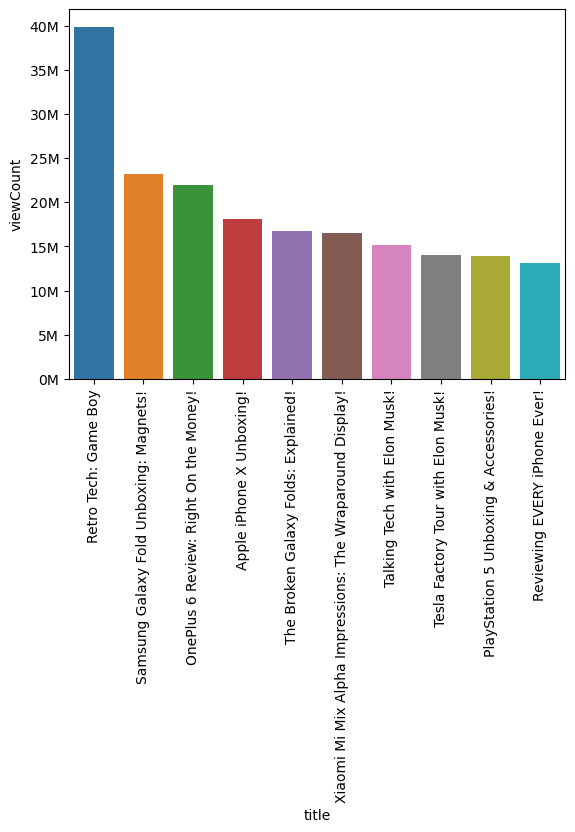

In [16]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = videos_df.sort_values('viewCount', ascending=False)[:10])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/10**6) + 'M'))


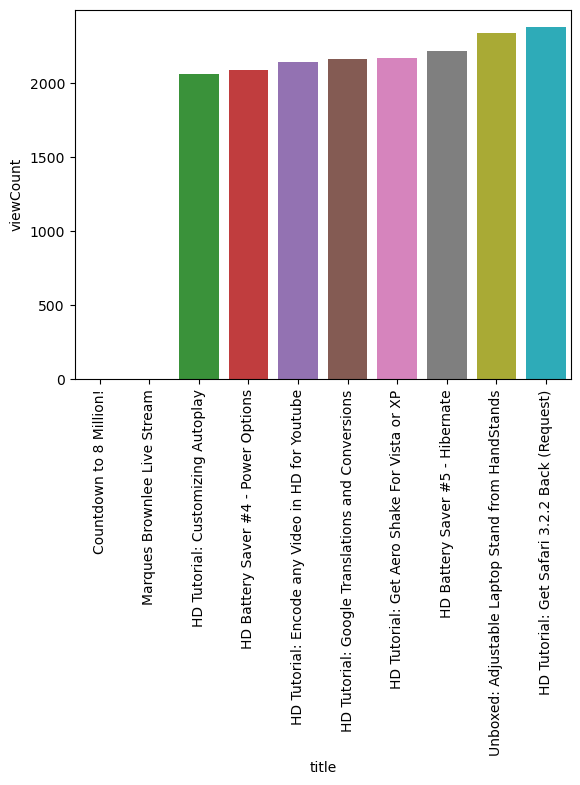

In [17]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = videos_df.sort_values('viewCount')[:10])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
# ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x) + 'K'))

# View distribution per video

<AxesSubplot:xlabel='viewCount', ylabel='Count'>

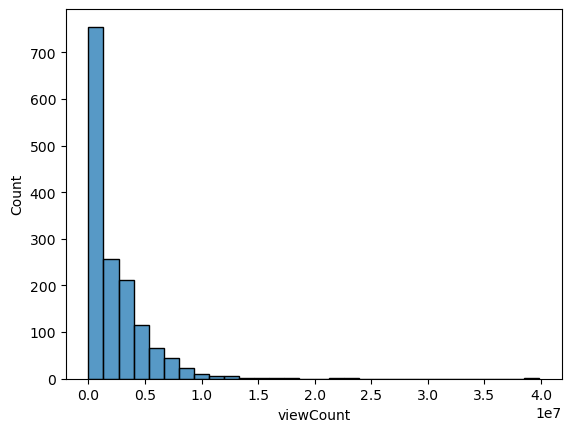

In [18]:
sns.histplot(data = videos_df, x = 'viewCount', bins = 30)

In [19]:
new_df = videos_df.loc[videos_df["viewCount"] >= 1e6]

<AxesSubplot:xlabel='viewCount', ylabel='Count'>

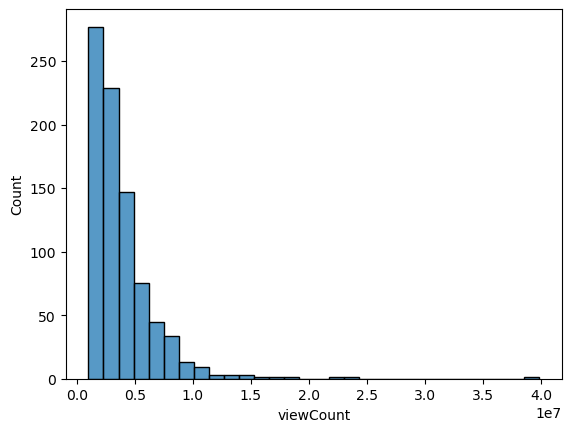

In [20]:
sns.histplot(data = new_df, x = 'viewCount', bins = 30)

In [21]:
videos_df['viewCount'].mean()

2199261.5362608116

# Views vs likes and comments

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

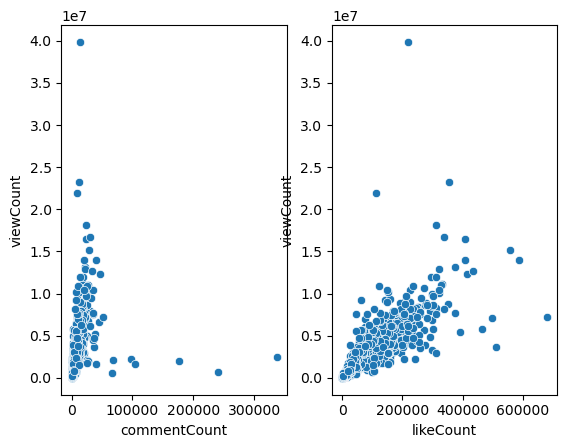

In [22]:
fig, ax = plt.subplots(1, 2)
sns.scatterplot(data = videos_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = videos_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

# Video Duration

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

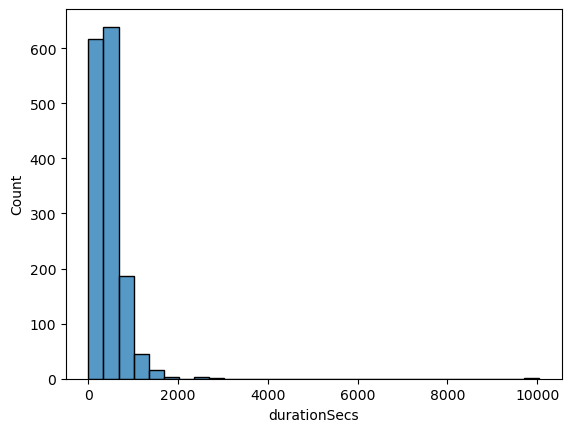

In [23]:
sns.histplot(data = videos_df, x = 'durationSecs', bins = 30)

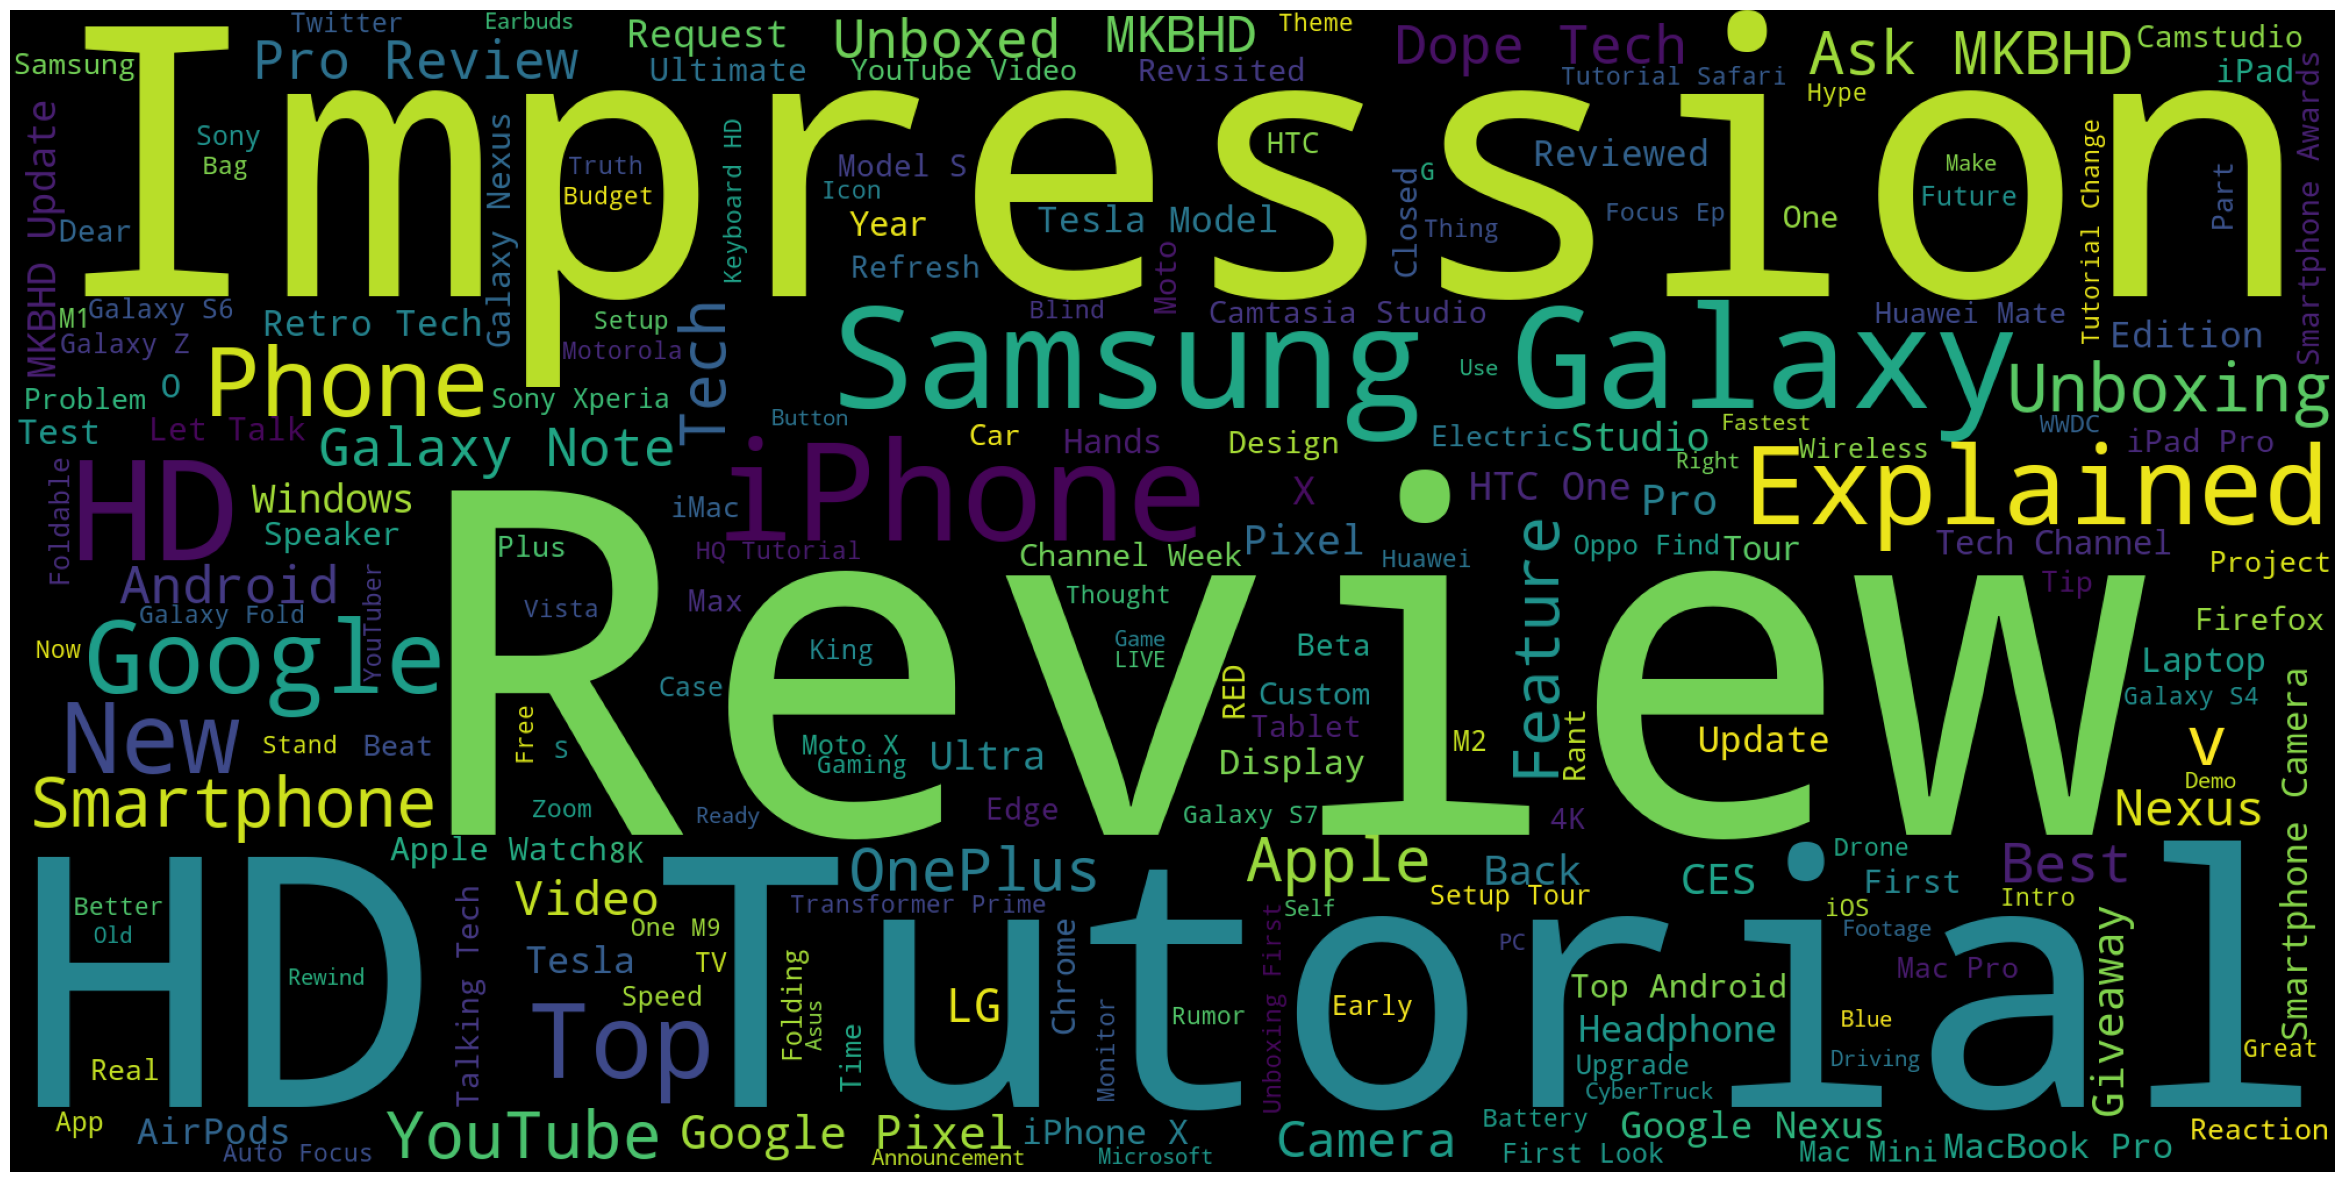

In [24]:
stop_words = set(stopwords.words('english'))
videos_df['title_no_stopwords'] = videos_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

allwords = list([a for b in videos_df['title_no_stopwords'].tolist() for a in b])
allwords_str = ' '.join(allwords)

def plot_cloud(wordcloud):
    plt.figure(figsize = (30, 20))
    plt.imshow(wordcloud)
    plt.axis("off")

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black',
                     colormap='viridis', collocations="False").generate(allwords_str)

plot_cloud(wordcloud)

# Uploading schedule

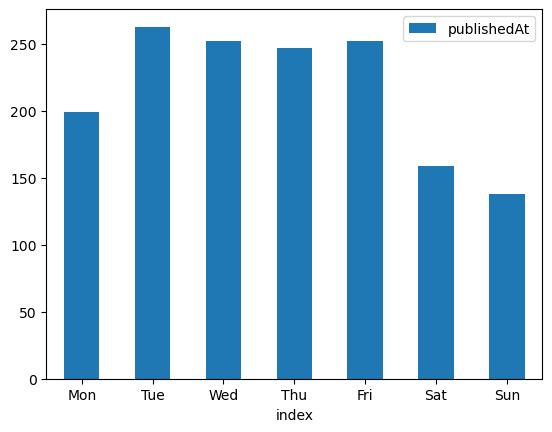

In [25]:
day_df = pd.DataFrame(videos_df['publishedAt'].value_counts())
day_df = day_df.reindex(date_name)
# plot, reset index to get an 'index' column
ax = day_df.reset_index().plot.bar(x='index', y='publishedAt', rot = 0)